In [43]:
POPU_STATE_PATH = '../data/processed/2020-2021-popu-estimate-by-state.csv'
PIT_BY_COC_PATH = '../data/processed/2015-2020-pit-demographic-by-coc.csv'
PIT_BY_STATE_PATH = '../data/processed/2007-2020-pit-estimates-by-state.csv'
STATE_CODE_PATH = '../data/raw/state_vs_code.csv'
MAP_PATH = '../data/maps/cb_2018_us_state_20m/cb_2018_us_state_20m.shp'
PIT_BY_COC_PATH_2007 = '../data/processed/2007-2020-pit-hic-estimate-by-coc.csv'
REGION_STATE_PATH = '../data/processed/us_census_bureau_regions_and_divisions.csv'

In [81]:
import pandas as pd
import geopandas as gpd
from matplotlib import pyplot as plt
popu_df = pd.read_csv(POPU_STATE_PATH)
coc_df = pd.read_csv(PIT_BY_COC_PATH)
state_df = pd.read_csv(PIT_BY_STATE_PATH)
state_codes = pd.read_csv(STATE_CODE_PATH).rename(columns={'State': 'geographic_area', 'Code': 'State'})
state_codes.head()

,geographic_area,Abbrev,State
0,Alabama,Ala.,AL
1,Alaska,Alaska,AK
2,Arizona,Ariz.,AZ
3,Arkansas,Ark.,AR
4,California,Calif.,CA


In [3]:
selected_cols = set(coc_df.columns)
selected_cols = selected_cols.intersection(set(state_df.columns))
selected_cols.add('State')


In [36]:
# pit by state
state_df = state_df[list(selected_cols)]
state_df.head()

,Overall Homeless - Age 18 to 24,Sheltered Total Homeless Individuals - Asian,Overall Homeless,Unsheltered Homeless Individuals - Under 18,Sheltered Total Homeless Individuals - Native Hawaiian or Other Pacific Islander,Unsheltered Homeless Individuals,Overall Homeless - Non-Hispanic/Non-Latino,Sheltered Total Homeless Individuals - Male,Overall Homeless Veterans,Overall Homeless Individuals,...,Unsheltered Homeless Individuals - Gender Non-Conforming,Overall Homeless Individuals - Asian,Sheltered Total Homeless - Under 18,Unsheltered Homeless - American Indian or Alaska Native,Unsheltered Homeless - Transgender,Sheltered Total Homeless Individuals - American Indian or Alaska Native,Sheltered Total Homeless - Age 18 to 24,Sheltered Total Homeless Individuals - Non-Hispanic/Non-Latino,Unsheltered Homeless - Age 18 to 24,Overall Homeless Veterans - Multiple Races
0,197,15,1949,0,20,221,1823,747,94,1445,...,0,15,325,111,0,528,191,1163,6,9
1,198,1,3351,4,6,1204,3214,837,329,2497,...,3,1,478,22,7,12,124,1263,74,8
2,258,2,2366,2,5,1203,2313,575,188,2073,...,1,4,153,20,2,18,81,850,177,0
3,,,,,,,,,,,...,,,,,,,,,,
4,824,26,10979,5,17,5278,8624,2045,921,8280,...,10,57,1590,578,24,242,352,2463,472,50


In [5]:
#Select only records for 2020
popu_cols = ["popu_estimate_2020",	"popu_estimate_2021","State", "geographic_area"]
popu_df = popu_df.merge(state_codes[['geographic_area', 'State']], on='geographic_area')[popu_cols]
popu_df.head()
# state_codes

,popu_estimate_2020,popu_estimate_2021,State,geographic_area
0,5024803,5039877.0,AL,Alabama
1,732441,732673.0,AK,Alaska
2,7177986,7276316.0,AZ,Arizona
3,3012232,3025891.0,AR,Arkansas
4,39499738,39237836.0,CA,California


In [6]:
state_df_2020 = state_df[state_df['Year'] == 2020]
state_df_2020.head()

,Overall Homeless - Age 18 to 24,Sheltered Total Homeless Individuals - Asian,Overall Homeless,Unsheltered Homeless Individuals - Under 18,Sheltered Total Homeless Individuals - Native Hawaiian or Other Pacific Islander,Unsheltered Homeless Individuals,Overall Homeless - Non-Hispanic/Non-Latino,Sheltered Total Homeless Individuals - Male,Overall Homeless Veterans,Overall Homeless Individuals,...,Unsheltered Homeless Individuals - Gender Non-Conforming,Overall Homeless Individuals - Asian,Sheltered Total Homeless - Under 18,Unsheltered Homeless - American Indian or Alaska Native,Unsheltered Homeless - Transgender,Sheltered Total Homeless Individuals - American Indian or Alaska Native,Sheltered Total Homeless - Age 18 to 24,Sheltered Total Homeless Individuals - Non-Hispanic/Non-Latino,Unsheltered Homeless - Age 18 to 24,Overall Homeless Veterans - Multiple Races
0,197,15,1949,0,20,221,1823,747,94,1445,...,0,15,325,111,0,528,191,1163,6,9
1,198,1,3351,4,6,1204,3214,837,329,2497,...,3,1,478,22,7,12,124,1263,74,8
2,258,2,2366,2,5,1203,2313,575,188,2073,...,1,4,153,20,2,18,81,850,177,0
3,,,,,,,,,,,...,,,,,,,,,,
4,824,26,10979,5,17,5278,8624,2045,921,8280,...,10,57,1590,578,24,242,352,2463,472,50


In [7]:
usa = gpd.read_file(MAP_PATH).rename(columns={'STUSPS': 'State'})[['State', 'geometry']]
usa.head()

,State,geometry
0,MD,"MULTIPOLYGON (((-76.04621 38.02553, -76.00734 ..."
1,IA,"POLYGON ((-96.62187 42.77925, -96.57794 42.827..."
2,DE,"POLYGON ((-75.77379 39.72220, -75.75323 39.757..."
3,OH,"MULTIPOLYGON (((-82.86334 41.69369, -82.82572 ..."
4,PA,"POLYGON ((-80.51989 40.90666, -80.51964 40.987..."


In [8]:
popu_df = popu_df.merge(usa, on='State')
popu_df.head()

,popu_estimate_2020,popu_estimate_2021,State,geographic_area,geometry
0,5024803,5039877.0,AL,Alabama,"POLYGON ((-88.46866 31.89386, -88.46866 31.933..."
1,732441,732673.0,AK,Alaska,"MULTIPOLYGON (((179.48132 51.97530, 179.58286 ..."
2,7177986,7276316.0,AZ,Arizona,"POLYGON ((-114.79968 32.59362, -114.80939 32.6..."
3,3012232,3025891.0,AR,Arkansas,"POLYGON ((-94.61792 36.49941, -94.36120 36.499..."
4,39499738,39237836.0,CA,California,"MULTIPOLYGON (((-118.59397 33.46720, -118.4847..."


In [9]:
import folium
import branca.colormap as cm
from IPython.display import display, HTML


In [10]:
popu_df = gpd.GeoDataFrame(popu_df, geometry="geometry")
popu_df.crs = usa.crs
popu_df = popu_df.to_crs('EPSG:4326')


In [11]:
popu_geo = gpd.GeoSeries(popu_df.set_index('State')['geometry']).to_json()


In [12]:
def create_map(df, viz_col, index_col):
    mymap = folium.Map(location=[39.60688671643651, -93.46949406298138], zoom_start=3,tiles=None)
    folium.TileLayer('CartoDB positron',name="Light Map",control=False).add_to(mymap)
    geo = gpd.GeoSeries(df.set_index(index_col)['geometry']).to_json()
    # myscale = (popu_df['popu_estimate_2020'].quantile((0,0.1,0.75,0.9,0.98,1))).tolist()
    folium.Choropleth(
    titles='My title',
    geo_data=geo,
    name='Choropleth',
    data=df,
    columns=[index_col, viz_col],
    key_on="feature.id",
    fill_color='YlGnBu',
    fill_opacity=0.6,
    line_opacity=1,
    legend_name='Population %',
    smooth_factor=0
    ).add_to(mymap)
    return mymap
    
        
    

### Population by State

In [13]:
create_map(popu_df, 'popu_estimate_2020', 'State')

In [14]:
viz_cols = ['Overall Homeless', 'Sheltered Total Homeless', 'Unsheltered Homeless']
state_norm = state_df_2020[['State'] + viz_cols + ['Year']].merge(popu_df, on='State')

for col in viz_cols:
    state_norm = state_norm.astype({col:'int32'})
    state_norm[col + ' Norm'] = state_norm[col]/state_norm['popu_estimate_2020']
    

In [15]:
state_norm.head()

,State,Overall Homeless,Sheltered Total Homeless,Unsheltered Homeless,Year,popu_estimate_2020,popu_estimate_2021,geographic_area,geometry,Overall Homeless Norm,Sheltered Total Homeless Norm,Unsheltered Homeless Norm
0,AK,1949,1725,224,2020,732441,732673.0,Alaska,"MULTIPOLYGON (((179.48132 51.97531, 179.58286 ...",0.002661,0.002355,0.000306
1,AL,3351,2052,1299,2020,5024803,5039877.0,Alabama,"POLYGON ((-88.46866 31.89386, -88.46866 31.933...",0.000667,0.000408,0.000259
2,AR,2366,1093,1273,2020,3012232,3025891.0,Arkansas,"POLYGON ((-94.61792 36.49941, -94.36120 36.499...",0.000785,0.000363,0.000423
3,AZ,10979,5458,5521,2020,7177986,7276316.0,Arizona,"POLYGON ((-114.79968 32.59362, -114.80939 32.6...",0.001530,0.000760,0.000769
4,CA,161548,47888,113660,2020,39499738,39237836.0,California,"MULTIPOLYGON (((-118.59397 33.46720, -118.4847...",0.004090,0.001212,0.002877


### Overall Homeless  Normalized by Population

In [16]:
create_map(state_norm, 'Overall Homeless Norm', 'State')

### Sheltered Total Homeless Normalized by Population

In [17]:
create_map(state_norm, 'Sheltered Total Homeless Norm', 'State')

### Unsheltered Homeless Normalized by Population

In [18]:
create_map(state_norm, 'Unsheltered Homeless Norm', 'State')

### **Top 10 states with highest/lowest homelessness count**

#### Top 10 states with highest homelessness count

In [19]:
state_norm.sort_values(by='Overall Homeless Norm', ascending=False)[['geographic_area', 'Overall Homeless Norm', 'Overall Homeless', 'popu_estimate_2020']].reset_index(drop=True).head(10)

,geographic_area,Overall Homeless Norm,Overall Homeless,popu_estimate_2020
0,District of Columbia,0.009245,6380,690093
1,New York,0.004528,91271,20154933
2,Hawaii,0.004448,6458,1451911
3,California,0.004090,161548,39499738
4,Oregon,0.003455,14655,4241544
5,Washington,0.002970,22923,7718785
6,Alaska,0.002661,1949,732441
7,Massachusetts,0.002560,17975,7022220
8,Nevada,0.002216,6900,3114071
9,Vermont,0.001728,1110,642495


In [20]:
state_norm.sort_values(by='Sheltered Total Homeless Norm', ascending=False)[['geographic_area', 'Sheltered Total Homeless Norm', 'Sheltered Total Homeless', 'popu_estimate_2020']].reset_index(drop=True).head(10)

,geographic_area,Sheltered Total Homeless Norm,Sheltered Total Homeless,popu_estimate_2020
0,District of Columbia,0.008299,5727,690093
1,New York,0.004302,86714,20154933
2,Massachusetts,0.002375,16681,7022220
3,Alaska,0.002355,1725,732441
4,Hawaii,0.001934,2808,1451911
5,Washington,0.001569,12109,7718785
6,Vermont,0.001550,996,642495
7,Maine,0.001436,1956,1362280
8,Oregon,0.001362,5778,4241544
9,California,0.001212,47888,39499738


In [21]:
state_norm.sort_values(by='Unsheltered Homeless Norm', ascending=False)[['geographic_area', 'Unsheltered Homeless Norm', 'Unsheltered Homeless', 'popu_estimate_2020']].reset_index(drop=True).head(10)

,geographic_area,Unsheltered Homeless Norm,Unsheltered Homeless,popu_estimate_2020
0,California,0.002877,113660,39499738
1,Hawaii,0.002514,3650,1451911
2,Oregon,0.002093,8877,4241544
3,Washington,0.001401,10814,7718785
4,Nevada,0.001352,4209,3114071
5,District of Columbia,0.000946,653,690093
6,Arizona,0.000769,5521,7177986
7,New Mexico,0.000595,1259,2117566
8,Florida,0.000587,12672,21569932
9,Idaho,0.000564,1043,1847772


#### Top 10 states with lowest homelessness count

In [22]:
state_norm.sort_values(by='Overall Homeless Norm', ascending=True)[['geographic_area', 'Overall Homeless Norm', 'Overall Homeless', 'popu_estimate_2020']].reset_index(drop=True).head(10)

,geographic_area,Overall Homeless Norm,Overall Homeless,popu_estimate_2020
0,Mississippi,0.000374,1107,2956870
1,Alabama,0.000667,3351,5024803
2,Louisiana,0.000682,3173,4651203
3,Virginia,0.000690,5957,8632044
4,North Dakota,0.000695,541,778962
5,West Virginia,0.000749,1341,1789798
6,Wisconsin,0.000766,4515,5892323
7,Arkansas,0.000785,2366,3012232
8,Connecticut,0.000807,2905,3600260
9,Illinois,0.000816,10431,12785245


In [23]:
state_norm.sort_values(by='Sheltered Total Homeless Norm', ascending=True)[['geographic_area', 'Sheltered Total Homeless Norm', 'Sheltered Total Homeless', 'popu_estimate_2020']].reset_index(drop=True).head(10)

,geographic_area,Sheltered Total Homeless Norm,Sheltered Total Homeless,popu_estimate_2020
0,Mississippi,0.000196,581,2956870
1,Arkansas,0.000363,1093,3012232
2,Alabama,0.000408,2052,5024803
3,Louisiana,0.000434,2020,4651203
4,Texas,0.000480,14017,29217653
5,South Carolina,0.000503,2583,5130729
6,Georgia,0.000567,6078,10725800
7,Virginia,0.000578,4989,8632044
8,West Virginia,0.000594,1064,1789798
9,Illinois,0.000638,8153,12785245


In [24]:
state_norm.sort_values(by='Unsheltered Homeless Norm', ascending=True)[['geographic_area', 'Unsheltered Homeless Norm', 'Unsheltered Homeless', 'popu_estimate_2020']].reset_index(drop=True).head(10)

,geographic_area,Unsheltered Homeless Norm,Unsheltered Homeless,popu_estimate_2020
0,North Dakota,0.000044,34,778962
1,Wisconsin,0.000055,324,5892323
2,Nebraska,0.000073,143,1961455
3,Connecticut,0.000090,325,3600260
4,Rhode Island,0.000099,108,1096229
5,Michigan,0.000103,1039,10067664
6,Maine,0.000104,141,1362280
7,Iowa,0.000104,333,3188669
8,Virginia,0.000112,968,8632044
9,Indiana,0.000142,966,6785644


In [25]:
state_norm.loc[state_norm.sort_values(by='Unsheltered Homeless Norm', ascending=False).index, 'Unsheltered Homeless Rank'] = list(range(1, len(state_norm) + 1))
state_norm.loc[state_norm.sort_values(by='Sheltered Total Homeless Norm', ascending=False).index, 'Sheltered Total Homeless Rank'] = list(range(1, len(state_norm) + 1))
state_norm.loc[state_norm.sort_values(by='Overall Homeless Norm', ascending=False).index, 'Overall Homeless Rank'] = list(range(1, len(state_norm) + 1))

In [26]:
state_norm[['geographic_area', "Overall Homeless Rank", "Unsheltered Homeless Rank",	"Sheltered Total Homeless Rank"]]

,geographic_area,Overall Homeless Rank,Unsheltered Homeless Rank,Sheltered Total Homeless Rank
0,Alaska,7.0,20.0,4.0
1,Alabama,50.0,23.0,49.0
2,Arkansas,44.0,14.0,50.0
3,Arizona,14.0,7.0,26.0
4,California,4.0,1.0,10.0
5,Colorado,11.0,11.0,11.0
6,Connecticut,43.0,48.0,31.0
7,District of Columbia,1.0,6.0,1.0
8,Delaware,22.0,40.0,14.0
9,Florida,17.0,9.0,34.0


## Scatterplot Overall Homeless Rank vs Unsheltered Homeless Rank vs Sheltered Homeless


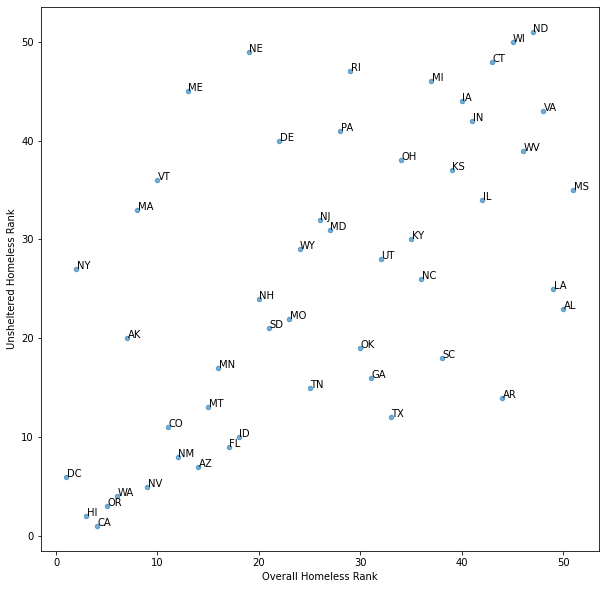

In [27]:
from matplotlib import pyplot as plt
ax = state_norm.plot.scatter(x='Overall Homeless Rank', y='Unsheltered Homeless Rank', figsize=(10, 10), s=20, alpha=0.6)
for i, txt in enumerate(state_norm.State):
   ax.annotate(txt, (state_norm['Overall Homeless Rank'].iat[i]+0.05, state_norm['Unsheltered Homeless Rank'].iat[i]), )
plt.show()

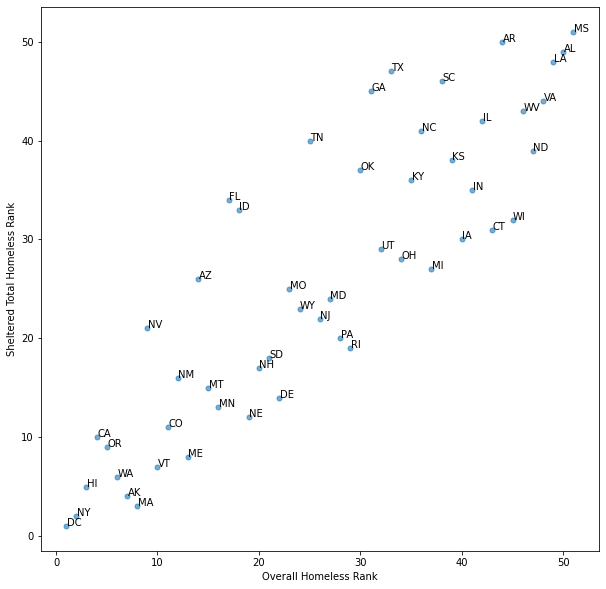

In [28]:
from matplotlib import pyplot as plt
ax = state_norm.plot.scatter(x='Overall Homeless Rank', y='Sheltered Total Homeless Rank', figsize=(10, 10), alpha=0.6, s=25)
for i, txt in enumerate(state_norm.State):
   ax.annotate(txt, (state_norm['Overall Homeless Rank'].iat[i]+0.05, state_norm['Sheltered Total Homeless Rank'].iat[i]))
plt.show()

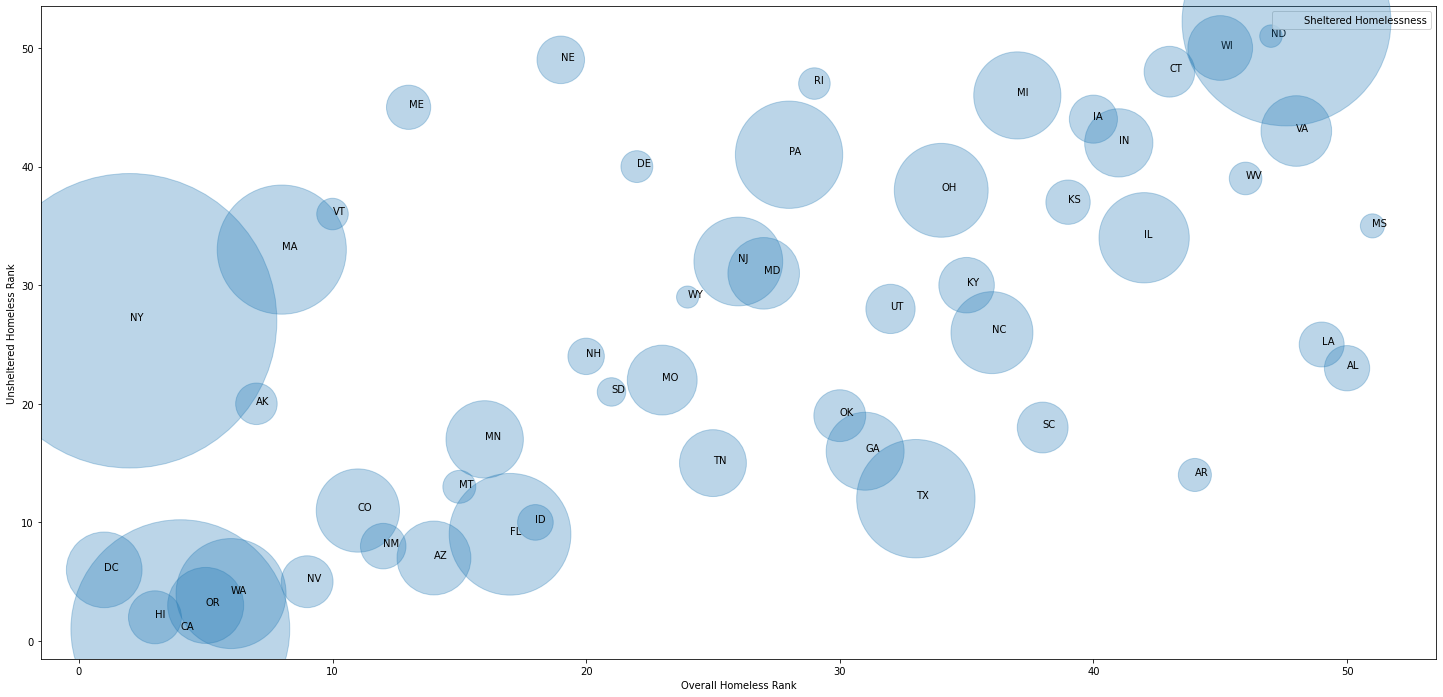

In [29]:
from matplotlib import pyplot as plt
ax = state_norm.plot.scatter(x='Overall Homeless Rank', y='Unsheltered Homeless Rank', figsize=(25, 12), s='Sheltered Total Homeless', alpha=0.3, label="Sheltered Homelessness")
for i, txt in enumerate(state_norm.State):
   ax.annotate(txt, (state_norm['Overall Homeless Rank'].iat[i], state_norm['Unsheltered Homeless Rank'].iat[i]), )
plt.show()

In [38]:
pit_state = pd.read_csv(PIT_BY_STATE_PATH)
pit_state = pit_state[pit_state['State'] != 'Total']
pit_state = pit_state[pit_state['State'].notna()]
# check all years contains data only from the 56 states
annual_states = pit_state.groupby('Year').size()
assert (annual_states.min() == annual_states.max()), "all years don't contain the same number of states"
print(pit_state['State'].unique())

['AK' 'AL' 'AR' 'AS' 'AZ' 'CA' 'CO' 'CT' 'DC' 'DE' 'FL' 'GA' 'GU' 'HI'
 'IA' 'ID' 'IL' 'IN' 'KS' 'KY' 'LA' 'MA' 'MD' 'ME' 'MI' 'MN' 'MO' 'MP'
 'MS' 'MT' 'NC' 'ND' 'NE' 'NH' 'NJ' 'NM' 'NV' 'NY' 'OH' 'OK' 'OR' 'PA'
 'PR' 'RI' 'SC' 'SD' 'TN' 'TX' 'UT' 'VA' 'VI' 'VT' 'WA' 'WI' 'WV' 'WY']


In [42]:
#some part of the below content copied from (https://www.notion.so/DS4A-Homelessness-project-06ec331063c14a2394c8f2351a19d600?p=9be7c707b6aa4a4f99f00f33a79bf559)
# make new dataframe with columns of interest
cols_interest = ['Year', 'Overall Homeless', 'Unsheltered Homeless', 'Sheltered ES Homeless']
# replacing cells with no value with zero
pit_state = pit_state[cols_interest  + ['State']].replace(' ', 0)
# coverting the type of the columns into integer 
pit_state = pit_state.astype({'Year':'int64', 'Overall Homeless':'int64', 'Unsheltered Homeless':'int64', 'Sheltered ES Homeless':'int64'})
pit_state.head()

,Year,Overall Homeless,Unsheltered Homeless,Sheltered ES Homeless,State
0,2020,1949,224,1347,AK
1,2020,3351,1299,1421,AL
2,2020,2366,1273,912,AR
3,2020,0,0,0,AS
4,2020,10979,5521,3483,AZ


In [32]:
#group by year and sum to get the total national homelessness for each year
total_homeless = pit_state[cols_interest].groupby('Year').sum()
total_homeless

,Overall Homeless,Unsheltered Homeless,Sheltered ES Homeless
Year,,,
2007,647258,255857,216659
2008,639784,253423,215276
2009,630227,226919,221474
2010,637077,233534,222455
2011,623788,231472,221457
2012,621553,231398,224599
2013,590364,195666,236658
2014,576450,175399,254327
2015,564708,173268,259297


In [33]:
#calculate the change in homelessness between the previous and current year
pct_change = total_homeless.pct_change()*100
pct_change

,Overall Homeless,Unsheltered Homeless,Sheltered ES Homeless
Year,,,
2007,NaN,NaN,NaN
2008,-1.154717,-0.951313,-0.638330
2009,-1.493785,-10.458404,2.879095
2010,1.086910,2.915137,0.442941
2011,-2.085933,-0.882955,-0.448630
2012,-0.358295,-0.031969,1.418786
2013,-5.017915,-15.441793,5.369125
2014,-2.356851,-10.357957,7.466048
2015,-2.036950,-1.214944,1.954177


In [34]:
pct_change.style.background_gradient(axis=0, cmap='YlOrRd')  

,Overall Homeless,Unsheltered Homeless,Sheltered ES Homeless
Year,,,
2007,nan,nan,nan
2008,-1.154717,-0.951313,-0.638330
2009,-1.493785,-10.458404,2.879095
2010,1.086910,2.915137,0.442941
2011,-2.085933,-0.882955,-0.448630
2012,-0.358295,-0.031969,1.418786
2013,-5.017915,-15.441793,5.369125
2014,-2.356851,-10.357957,7.466048
2015,-2.036950,-1.214944,1.954177


In [48]:
#file that contains states and regions
region_state = pd.read_csv(REGION_STATE_PATH).rename(columns={'State': 'State Name', 'State Code': 'State'})
region_state.head()

,State Name,State,Region,Division
0,Alaska,AK,West,Pacific
1,Alabama,AL,South,East South Central
2,Arkansas,AR,South,West South Central
3,Arizona,AZ,West,Mountain
4,California,CA,West,Pacific


In [56]:
#merge pit_state and region_state to get a new dataframe with region field 
pit_region = pit_state.merge(region_state, on='State', how='outer')
pit_region.head()

,Year,Overall Homeless,Unsheltered Homeless,Sheltered ES Homeless,State,State Name,Region,Division
0,2020,1949,224,1347,AK,Alaska,West,Pacific
1,2019,1907,273,1218,AK,Alaska,West,Pacific
2,2018,2016,309,1248,AK,Alaska,West,Pacific
3,2017,1845,294,1017,AK,Alaska,West,Pacific
4,2016,1940,442,1007,AK,Alaska,West,Pacific


In [95]:
#Assign "Other" to states aren't matched with a region
pit_region['Region'] = pit_region['Region'].fillna("Other")
print('States that doesnt have Region: ', pit_region[pit_region['Region'] == 'Other']['State'].unique())
pit_region['Region'].unique()

States that doesnt have Region:  ['AS' 'GU' 'MP' 'PR' 'VI']


array(['West', 'South', 'Other', 'Northeast', 'Midwest'], dtype=object)

In [94]:
pit_region_sum = pit_region.groupby('Region').agg({'Overall Homeless': 'sum', 'Unsheltered Homeless':'sum', 'Sheltered ES Homeless':'sum'})
pit_region_sum = pit_region_sum.sort_values('Overall Homeless', ascending=False)
pit_region_sum

,Overall Homeless,Unsheltered Homeless,Sheltered ES Homeless
Region,,,
West,3039268,1673395,731212
South,2318486,930787,823480
Northeast,1849968,129709,1361535
Midwest,1048341,183311,500506
Other,77081,58060,7153


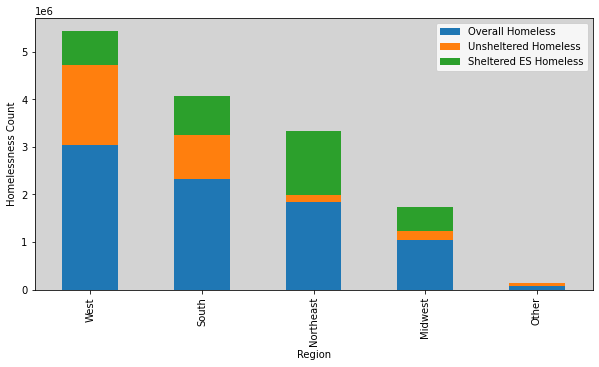

In [88]:
ax = pit_region_sum.plot(kind='bar', stacked=True, figsize=(10, 5))
plt.ylabel('Homelessness Count')
ax.set_facecolor('lightgrey')